In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# NN models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tqdm import tqdm

# model tuning
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

C:\Users\Alice\anaconda3\envs\hackathon\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Alice\anaconda3\envs\hackathon\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Alice\anaconda3\envs\hackathon\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Alice\anaconda3\envs\hackathon\lib\site-packages\ten

In [3]:
# Get path to data directory
import os
workingdir = os.path.abspath(os.getcwd())
datadir = workingdir + '\data'

In [4]:
expressiondir = datadir + "\\facial_expressions"

In [5]:
expressiondir

'D:\\covidhackathon\\data\\facial_expressions'

In [6]:
datafile = expressiondir + '/data/legend.csv'
datafile2 = expressiondir + '/data/500_picts_satz.csv'
imagedir = expressiondir + '\\images'

In [7]:
face1 = pd.read_csv(datafile, index_col = False)
face2 = pd.read_csv(datafile2, names = face1.columns, index_col = False)
faces = pd.concat([face1,face2])

In [35]:
faces = faces[1:] # First image doesn't work
faces = faces.reset_index(drop = True)

In [36]:
faces

,user.id,image,emotion
0,628,facial-expressions_2868584k.jpg,3
1,628,facial-expressions_2868582k.jpg,4
2,302,Aaron_Eckhart_0001.jpg,6
3,302,Aaron_Guiel_0001.jpg,5
4,302,Aaron_Patterson_0001.jpg,6
...,...,...,...
14183,906,Tim_Pawlenty_0001.jpg,neutral
14184,906,Tim_Robbins_0001.jpg,neutral
14185,906,Tim_Robbins_0002.jpg,neutral
14186,906,Tim_Robbins_0003.jpg,neutral


In [37]:
faces.emotion.unique()

array([3, 4, 6, 5, 8, 7, 1, 2, 'fear', 'happiness', 'neutral', 'anger',
       'sad'], dtype=object)

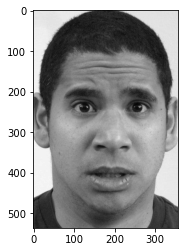

In [43]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

idx = 1
image1 = imagedir + '/' + faces.image.iloc[idx]
img=mpimg.imread(image1)
if img.ndim>2:
    img = rgb2gray(img)
plt.imshow(img, cmap = 'gray')

In [44]:
faces['emotion']=faces['emotion'].apply(str.lower)

In [40]:
class_names = faces.emotion.unique()
NUM_CLASSES = len(class_names)
class_names

array([3, 4, 6, 5, 8, 7, 1, 2, 'fear', 'happiness', 'neutral', 'anger',
       'sad'], dtype=object)

In [65]:
print(faces.columns)
X_file = faces.image

Index(['user.id', 'image', 'emotion'], dtype='object')


In [66]:
X_file[0]

'facial-expressions_2868584k.jpg'

# Start

In [8]:
file_labels = tf.data.experimental.CsvDataset(datafile, record_defaults=[tf.string, tf.string, tf.int32], header=True).shuffle(10000)

In [9]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL = 350, 350, 3
NUM_CLASSES = 8; # anger, contempt, disgust, fear, happiness, neutral, sad, sadness, surprise

def DecodeJPG(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def ProcessFiles(data_id, im_filename, emotion):
    full_filename = imagedir + '\\' + im_filename
    img = tf.io.read_file(full_filename)
    img = DecodeJPG(img)
    return img, emotion-1

In [10]:
img_labels = file_labels.map(ProcessFiles, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64).repeat()
img_labels_val = img_labels.take(2000)
img_labels_tra = img_labels.skip(2000)

In [11]:
iterator = img_labels.make_initializable_iterator()
next_op = iterator.get_next()

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
with tf.Session() as sess:
    sess.run(iterator.initializer)
    sess.run(tf.tables_initializer())
    img, lab = sess.run(next_op)
    print(lab)

[5 5 5 4 5 5 4 4 4 5 4 5 7 5 5 4 4 4 0 4 5 5 4 5 4 5 5 7 5 4 5 5 5 4 5 4 5
 5 5 5 5 4 4 4 4 5 5 4 5 4 5 5 4 4 4 5 5 5 5 5 4 4 4 4]


In [13]:
#We will create a simple architecture with 2 convolutional layers, one dense hidden layer and an output layer.
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),strides = (2,2), padding = 'same', activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL)))
model.add(Conv2D(64, (3, 3), strides = (2,2), activation='relu'))
model.add(Conv2D(64, (3, 3), strides = (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [14]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 175, 175, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3612800   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total para

In [ ]:
history = model.fit(x=img_labels_tra, epochs=1, steps_per_epoch=800, verbose=1, validation_data=img_labels_val)

 61/800 [=>............................] - ETA: 54:07 - loss: 1.0683 - acc: 0.4959

In [56]:
model.save('initialmodelval')

In [1]:
prediction = model.predict_classes(img_labels_val)

NameError: name 'model' is not defined

In [24]:
img_labels_tra

<DatasetV1Adapter shapes: ((?, 350, 350, 3), (?,)), types: (tf.float32, tf.string)>

In [ ]:
face2

In [11]:
# train_image = []
# for i in tqdm(range(X_file.shape[0])):
#     image = imagedir + '/' + X_file[i]
#     img=mpimg.imread(image1)
#     if img.ndim>2:
#         img = rgb2gray(img)
#     train_image.append(img)

100%|████████████████████████████████████████████████████████████████████████████| 14189/14189 [02:52<00:00, 82.39it/s]


In [12]:
len(train_image)

14189

In [13]:
train_label = faces.emotion

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_image, train_label, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2